In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import utils
import torch 
from torch.autograd import Variable
from Modules import VAE
import torch.nn as nn
import torch.nn.functional as F

filename = "/home/wafa/Desktop/study/sketchRNN/aaron_sheep.npz"
load_data = np.load(filename, encoding = 'latin1')
train_set = load_data['train'][:200]
test_set = load_data['test'][:100]

nb_steps = 10
feature_len=5
batch_size = 6
max_seq_len=250

train_set = utils.DataLoader(train_set, batch_size)
test_set = utils.DataLoader(test_set, batch_size)

total images <= max_seq_len is 200
total images <= max_seq_len is 100


In [3]:
class Encoder(nn.Module):
    
    def __init__(self, strokeSize, batchSize, Nh, Nz):
        super(Encoder, self).__init__()
        self.Nz = Nz
        self.cell = nn.LSTM(strokeSize, Nh//2, 1, bidirectional=True, batch_first=True)
        self.mu = nn.Linear(Nh, Nz)
        self.sigma = nn.Linear(Nh, Nz)
        self.h0 = nn.Linear(Nz, Nh)

    def forward(self, x):
        _, (hn, cn) = self.cell(x)
        hn = Variable(torch.cat((hn.data[0],hn.data[1]),1))
        sigma = self.sigma(hn)
        mu = self.mu(hn)
        sigma = torch.exp( sigma * 0.5)
        eps = Variable(torch.randn(self.Nz))
        z = mu + sigma * eps
        return F.tanh(self.h0(z)), z, mu, sigma


In [4]:
class Decoder(nn.Module):
    
    def __init__(self, strokeSize, batchSize, Nh, Nz, Ny):
        super(Decoder, self).__init__()
        self.Nh = Nh
        self.cell = nn.LSTM(strokeSize+Nz, Nh, 1, batch_first=True)
        self.y = nn.Linear(Nh, Ny)
    
    def forward(self, x):
        output, (hn, cn) = self.cell(x)
        #print("avant reshape", output.size())
        #print(output.contiguous().view(-1, self.Nh).size())
        output = output.contiguous().view(-1, self.Nh)
        #print("after", output.size())
        y = self.y(output)
        return y  

In [5]:
class SketchRNN(nn.Module):
    
    def __init__(self, strokeSize, batchSize, Nh, Nz, Ny, max_seq_len):
        super(SketchRNN, self).__init__()
        self.batchSize = batchSize
        self.max_seq_len = max_seq_len
        self.Nz = Nz
        self.encoder = Encoder(strokeSize, batchSize, Nh, Nz)
        self.decoder = Decoder(strokeSize, batchSize, Nh, Nz, Ny)
        
    def forward(self, x):
        # we don't take the inisiale S0 in the encoder so we do the 1:
        h0, z, mu, sigma = self.encoder(x[:, 1:250+1, :])
        #here we take S0
        new_input = torch.cat((x[:, :250, :], z.view(self.batchSize, 1, self.Nz).expand(self.batchSize, self.max_seq_len, self.Nz)), 2)
        y = self.decoder(new_input)
        return y, mu, sigma


In [6]:
def bi_normal(x1, x2, mu1, mu2, s1, s2, rho):
    
    x1 = x1.contiguous().view(-1, 1).expand(x1.size(0), M)
    x2 = x2.contiguous().view(-1, 1).expand(x1.size(0), M)
    norm1 = x1 - mu1
    norm2 = x2 - mu2
    z = torch.div(norm1, s1).pow(2) + torch.div(norm2, s2).pow(2) - 2 * torch.div(torch.mul(rho, torch.mul(norm1, norm2)), torch.mul(s1,s2))
    coef = torch.exp(-z/(2*(1-rho.pow(2))))
    #print(coef)
    denom = 2 * F.math.pi * s1 * s2 * torch.sqrt(1-rho.pow(2))
    #print(denom)
    result = torch.div(coef, denom)
    return result


def loss(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen_logits, x1, x2, pen, seq_len):
    
    indices = []
    for i in range(len(s)): indices += [a+250*i for a in range(s[i])]
    #indices = torch.LongTensor(indices)
    ls = bi_normal(x1[indices,], x2[indices,], z_mu1[indices,], z_mu2[indices,], z_sigma1[indices,], z_sigma2[indices,], z_corr[indices,])
    ls = torch.mul(ls, z_pi[indices,])
    ls = torch.sum(ls, 1, keepdim=True) # TODO change to Ns not Nmax
    ls = - torch.log(ls + 1e-6)
    ls = torch.mean(ls)
    
    lp = torch.log(z_pen_logits)
    lp = torch.mul(lp, pen)
    lp = - torch.sum(lp, 1, keepdim=True)
    lp = torch.mean(lp)
    
    return ls+lp

In [13]:
M = 5
sketchRnn = SketchRNN(5, 6, 100, 32, 6*M+3, 250)
lr=1e-2
optimizer = optim.Adam(sketchRnn.parameters(),lr) 
los = []
lok = []
for _ in range(500):
    optimizer.zero_grad()
    _, x, s = train_set.random_batch()
    x = Variable(torch.from_numpy(x).type(torch.FloatTensor))
    y, mu, sigma = sketchRnn(x)
    z_pen_logits = y[:, -3:]
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = torch.chunk(y[:, :-3], 6, dim=1)
    z_pi = F.sigmoid(z_pi)
    z_pen_logits = F.sigmoid(z_pen_logits)
    z_sigma1 = torch.exp(z_sigma1)
    z_sigma2 = torch.exp(z_sigma2)
    z_corr = F.tanh(z_corr)
    targets = x[:, 1:250+1, :].contiguous().view(-1, 5)
    x1 = targets[:,0]
    x2 = targets[:,1]
    pen = targets[:,2:]
    lr = loss(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_pen_logits, x1, x2, pen, s)
    L_kl = -0.5 * torch.sum(1 + sigma- mu.pow(2) - sigma.exp())
    #print(lr.data[0])
    los.append(lr.data[0])
    lok.append(L_kl.data[0])
    (lr + 0.25 * L_kl).backward()
    optimizer.step()
    

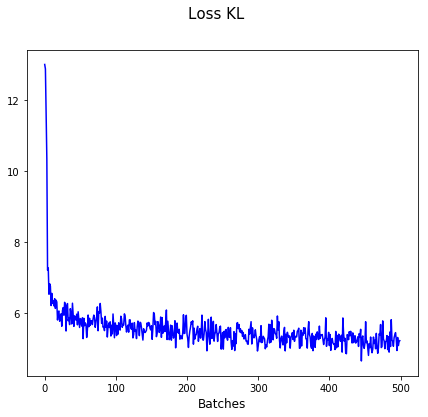

In [14]:
fig = plt.figure(figsize=(7,6))    
fig.suptitle("Loss KL",fontsize=15)
plt.plot(range(len(los)),los, 'b-')
plt.xlabel("Batches", fontsize=12)
plt.show()

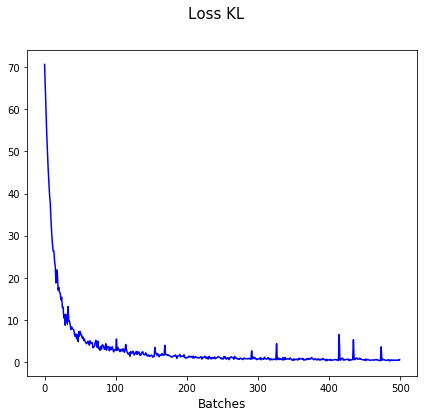

In [15]:
fig = plt.figure(figsize=(7,6))    
fig.suptitle("Loss KL",fontsize=15)
plt.plot(range(len(lok)),lok, 'b-')
plt.xlabel("Batches", fontsize=12)
plt.show()

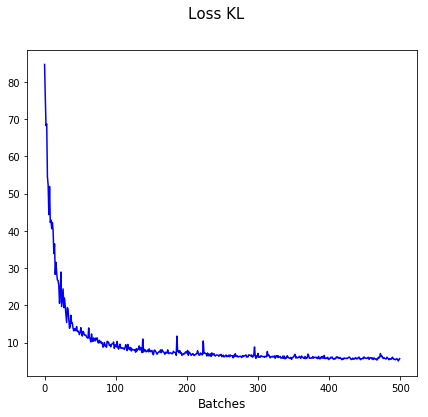

In [12]:
fig = plt.figure(figsize=(7,6))    
fig.suptitle("Loss KL",fontsize=15)
plt.plot(range(len(los)),los, 'b-')
plt.xlabel("Batches", fontsize=12)
plt.show()

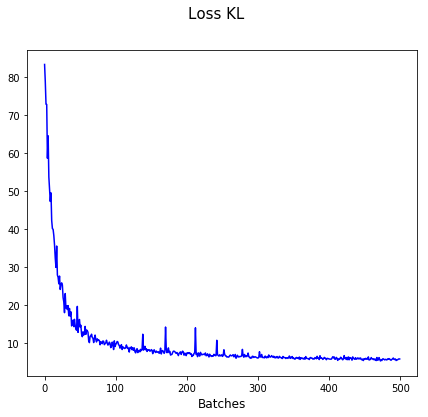

In [10]:
fig = plt.figure(figsize=(7,6))    
fig.suptitle("Loss KL",fontsize=15)
plt.plot(range(len(los)),los, 'b-')
plt.xlabel("Batches", fontsize=12)
plt.show()